<a href="https://colab.research.google.com/github/kjcoursera/NLP/blob/master/sentimental_analysis_using_BERT_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)
!pip install transformers==2.5.1

2.4.0
     |████████████████████████████████| 501kB 8.0MB/s 
     |████████████████████████████████| 133kB 13.9MB/s 
     |████████████████████████████████| 1.2MB 15.8MB/s 
     |████████████████████████████████| 890kB 32.5MB/s 
     |████████████████████████████████| 3.7MB 41.0MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 7.2MB 39.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8fa8d65c5d944bb4502cf6d7b71e3f835a096041d54bc94aec7f22ae7f967b50
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.51 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV

!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

df = pd.read_csv("reviews.csv")

df.head()

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.0MB/s]


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
df.shape

(15746, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


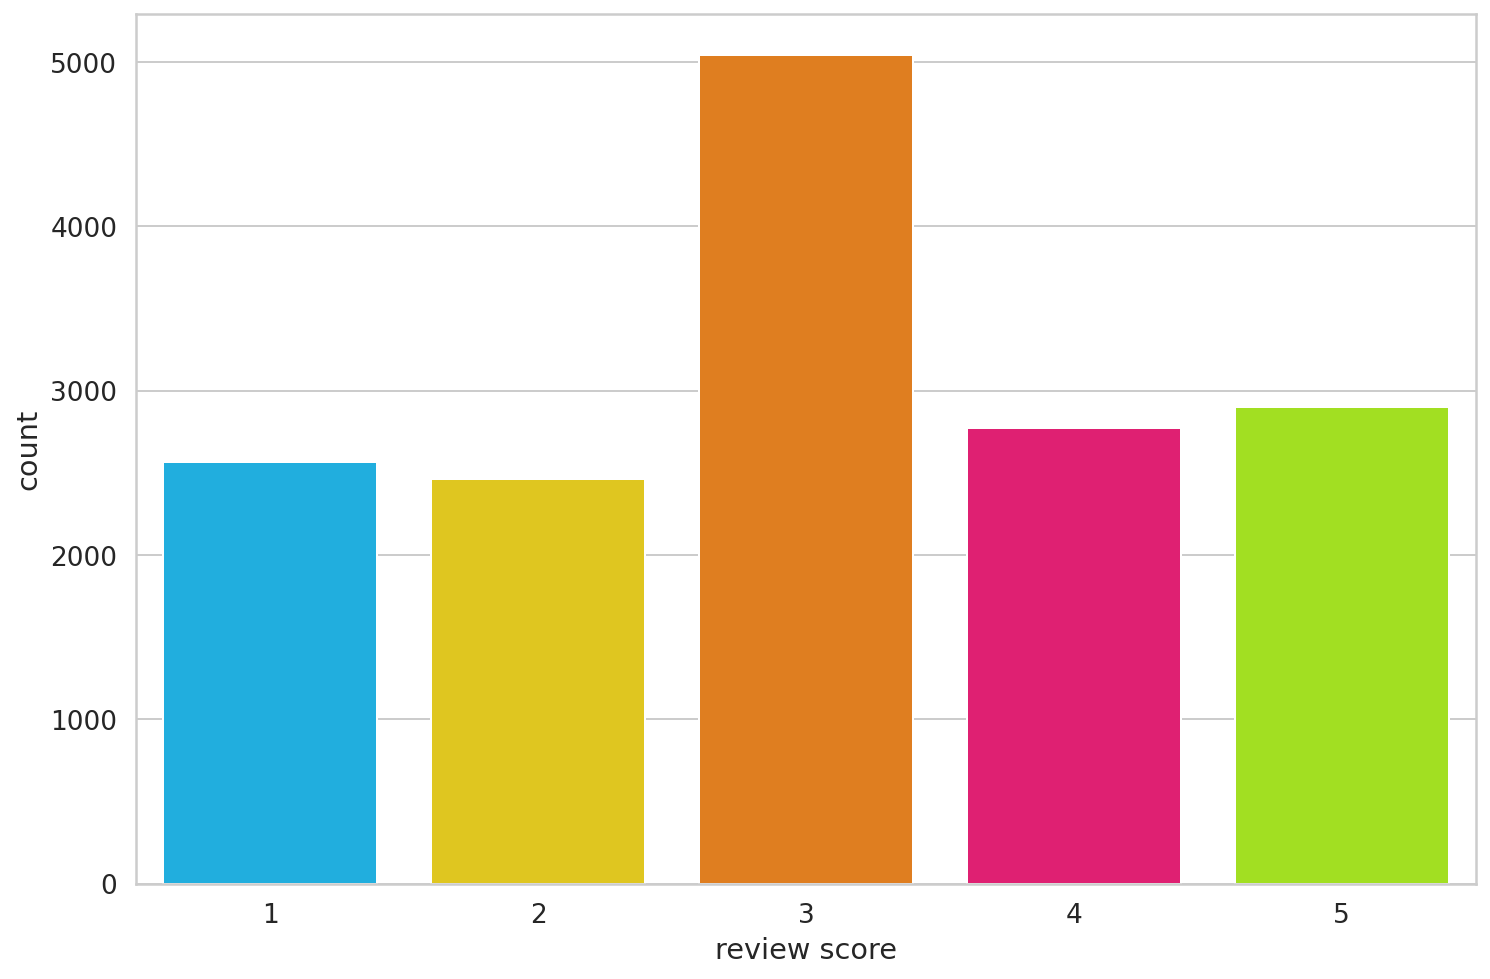

In [7]:
sns.countplot(df.score)

plt.xlabel('review score');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


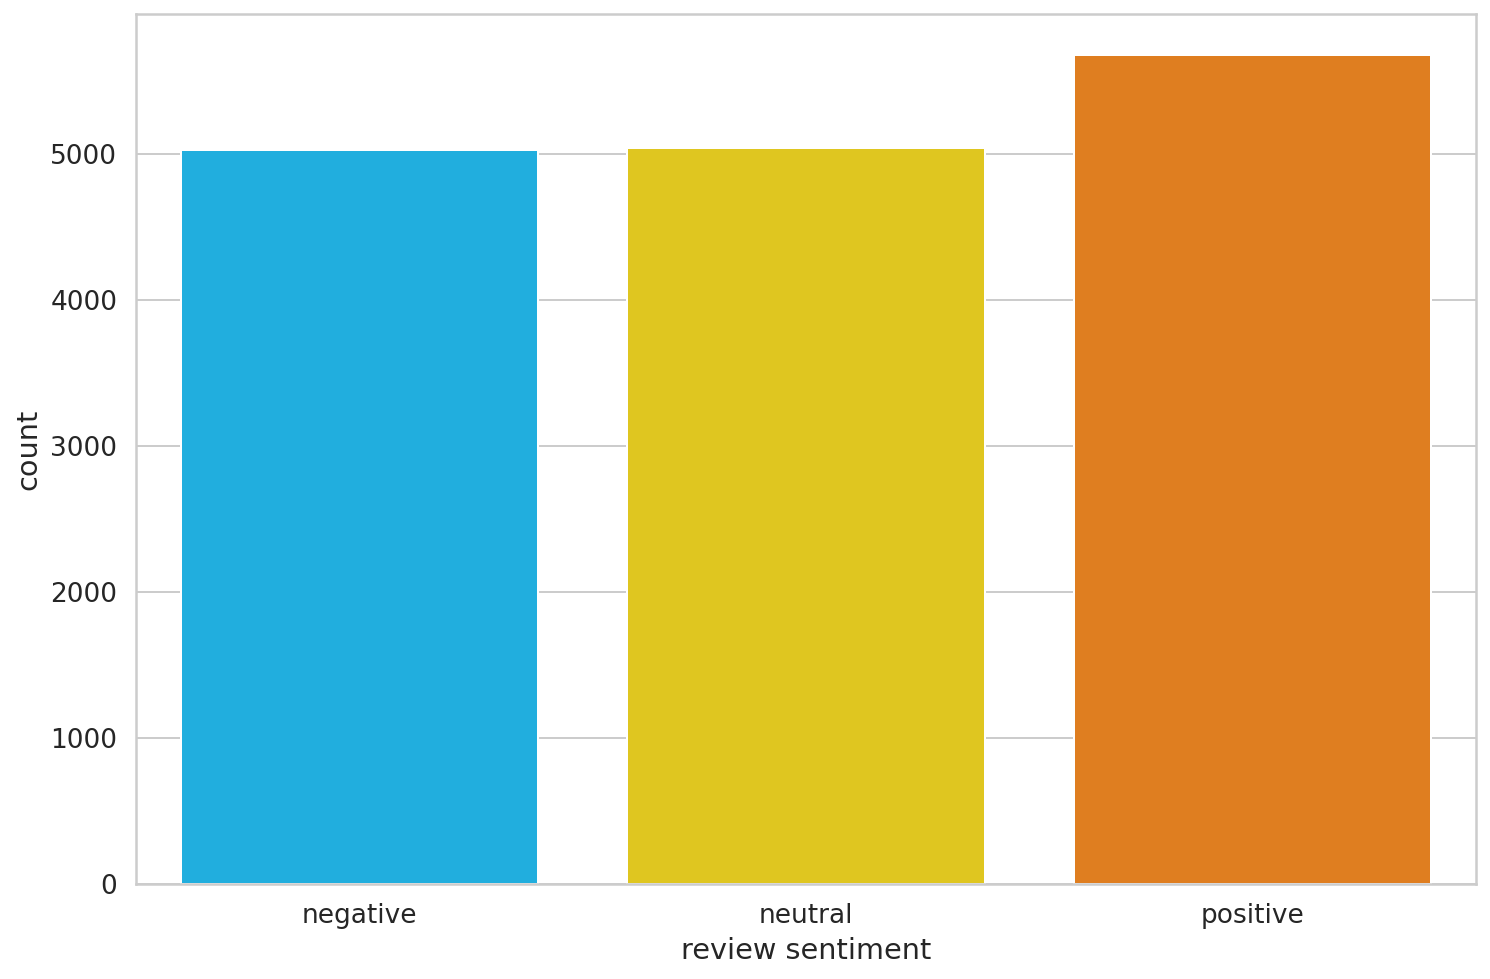

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <=2:
    return 0
  elif rating == 3 :
    return 1
  else :
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)

plt.xlabel('review sentiment')

ax.set_xticklabels(class_names);

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [10]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks because of COVID.'

In [12]:
tokens =  tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')

print(f'   Tokens: {tokens}')

print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks because of COVID.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', 'because', 'of', 'CO', '##VI', '##D', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 1272, 1104, 18732, 23314, 2137, 119]


In [13]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks because of corona.'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')

print(f'   Tokens: {tokens}')

print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks because of corona.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', 'because', 'of', 'co', '##rona', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 1272, 1104, 1884, 15789, 119]


In [14]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [16]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [17]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [18]:
encoding = tokenizer.encode_plus(

  sample_txt,

  max_length=32,

  add_special_tokens=True, # Add '[CLS]' and '[SEP]'

  return_token_type_ids=False,

  pad_to_max_length=True,

  return_attention_mask=True,

  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
print(len(encoding['input_ids'][0]))

encoding['input_ids'][0]

32


tensor([  101,  1332,  1108,   146,  1314,  1796,   136,   146,  1821,  5342,
         1120,  1313,  1111,   123,  2277,  1272,  1104,  1884, 15789,   119,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [20]:
print(len(encoding['attention_mask'][0]))

encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [21]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 'because',
 'of',
 'co',
 '##rona',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [22]:
token_lens = []

for txt in df.content:

  tokens = tokenizer.encode(txt, max_length=512)

  token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


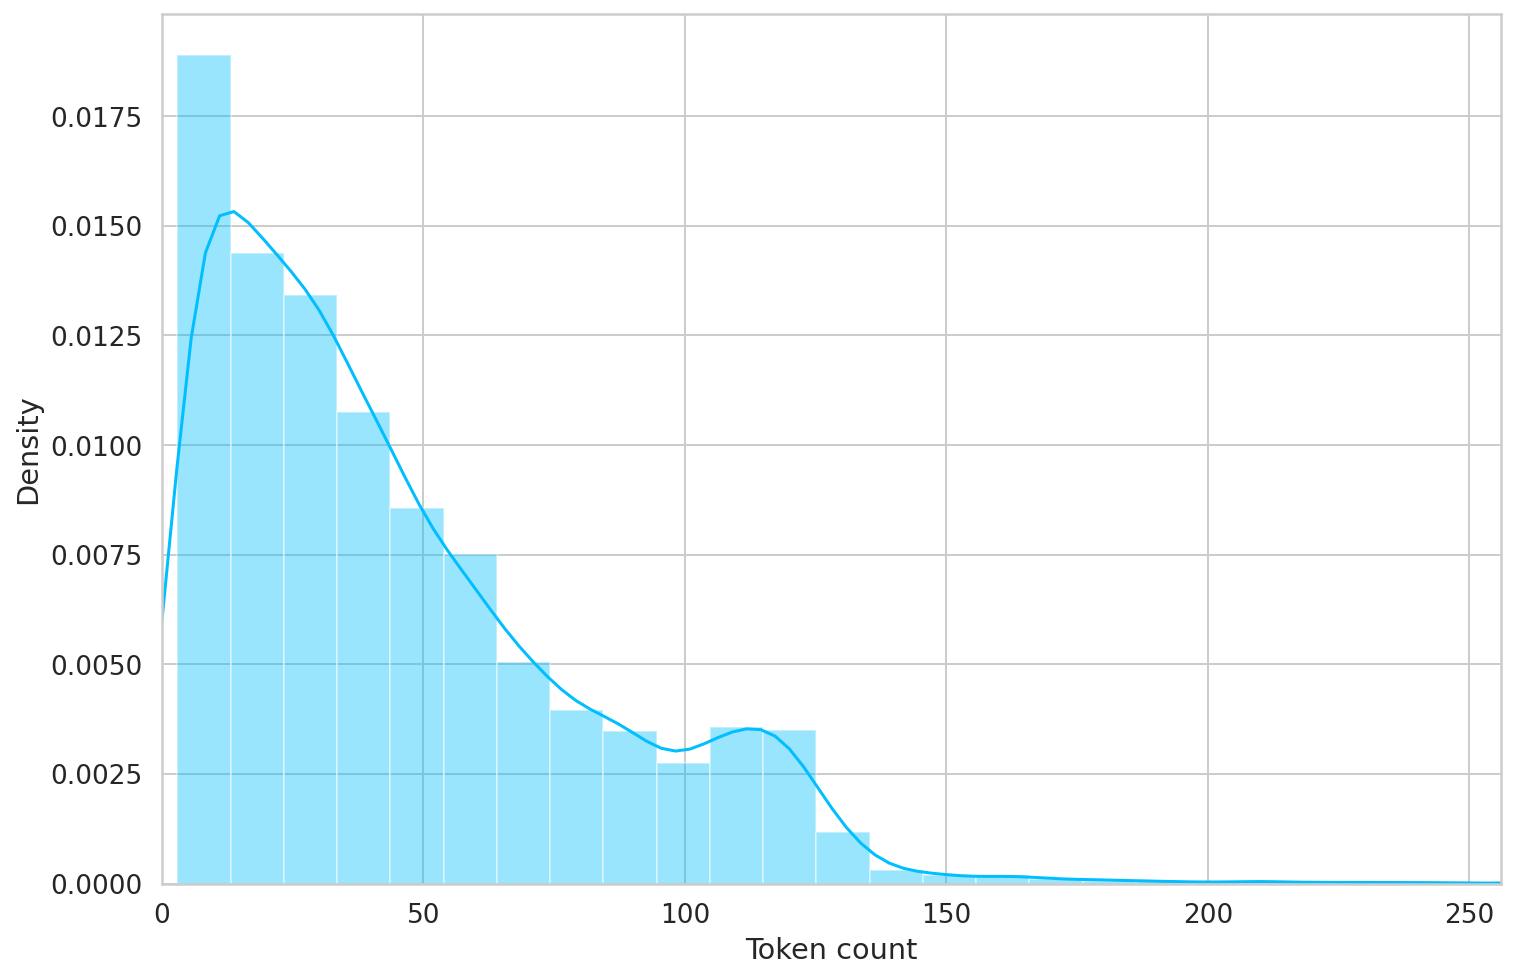

In [23]:
sns.distplot(token_lens)

plt.xlim([0, 256]);

plt.xlabel('Token count');

In [24]:
MAX_LEN = 160

In [25]:
df_train, df_test = train_test_split(df,test_size=0.97,random_state=RANDOM_SEED)

df_val, df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)

In [26]:
df_train.shape, df_val.shape, df_test.shape

((472, 12), (7637, 12), (7637, 12))

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472 entries, 606 to 7270
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              472 non-null    object
 1   userImage             472 non-null    object
 2   content               472 non-null    object
 3   score                 472 non-null    int64 
 4   thumbsUpCount         472 non-null    int64 
 5   reviewCreatedVersion  410 non-null    object
 6   at                    472 non-null    object
 7   replyContent          222 non-null    object
 8   repliedAt             222 non-null    object
 9   sortOrder             472 non-null    object
 10  appId                 472 non-null    object
 11  sentiment             472 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 47.9+ KB


In [28]:
df.content.head()

0    Update: After getting a response from the deve...
1    Used it for a fair amount of time without any ...
2    Your app sucks now!!!!! Used to be good but no...
3    It seems OK, but very basic. Recurring tasks n...
4    Absolutely worthless. This app runs a prohibit...
Name: content, dtype: object

In [29]:
df.content[1]


'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!'

In [30]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):

    self.reviews = reviews

    self.targets = targets

    self.tokenizer = tokenizer

    self.max_len = max_len

  def __len__(self):

    return len(self.reviews)

  def __getitem__(self, item):

    review = str(self.reviews[item])

    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(

      review,

      add_special_tokens=True,

      max_length=self.max_len,

      return_token_type_ids=False,

      pad_to_max_length=True,

      return_attention_mask=True,

      return_tensors='pt',

    )

    return {

      'review_text': review,

      'input_ids': encoding['input_ids'].flatten(),

      'attention_mask': encoding['attention_mask'].flatten(),

      'targets': torch.tensor(target, dtype=torch.long)

    }

In [31]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(

    reviews=df.content.to_numpy(),

    targets=df.sentiment.to_numpy(),

    tokenizer=tokenizer,

    max_len=max_len

  )

  return DataLoader(

    ds,

    batch_size=batch_size,

    num_workers=4

  )



In [32]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [35]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [36]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [37]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [38]:
bert_model.config.hidden_size

768

In [39]:
pooled_output.shape

torch.Size([1, 768])

In [40]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):

    super(SentimentClassifier, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    self.drop = nn.Dropout(p=0.3)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    output = self.drop(pooled_output)

    return self.out(output)

In [41]:
model = SentimentClassifier(len(class_names))

model = model.to(device)

In [42]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length

print(attention_mask.shape) # batch size x seq length



torch.Size([16, 160])
torch.Size([16, 160])


In [43]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [44]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

   

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  

  return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
     

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      #print(np.mean(losses))
  return correct_predictions.double() / n_examples, np.mean(losses)

In [46]:
print(EPOCHS)

5


In [47]:
history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)

  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)

  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss 1.0764758706092834 accuracy 0.4343220338983051
Val   loss 0.8996976959406082 accuracy 0.5614770197721618

Epoch 2/5
----------
Train loss 0.8111791729927063 accuracy 0.6228813559322034
Val   loss 0.8707451787952599 accuracy 0.5816420060233076

Epoch 3/5
----------
Train loss 0.6112987856070201 accuracy 0.7076271186440678
Val   loss 0.9375838775764449 accuracy 0.5889747282964515

Epoch 4/5
----------
Train loss 0.47476013203461964 accuracy 0.8177966101694916
Val   loss 0.9556651561517097 accuracy 0.6252455152546812

Epoch 5/5
----------
Train loss 0.29219090317686397 accuracy 0.902542372881356
Val   loss 1.0014244043053941 accuracy 0.631137881367029



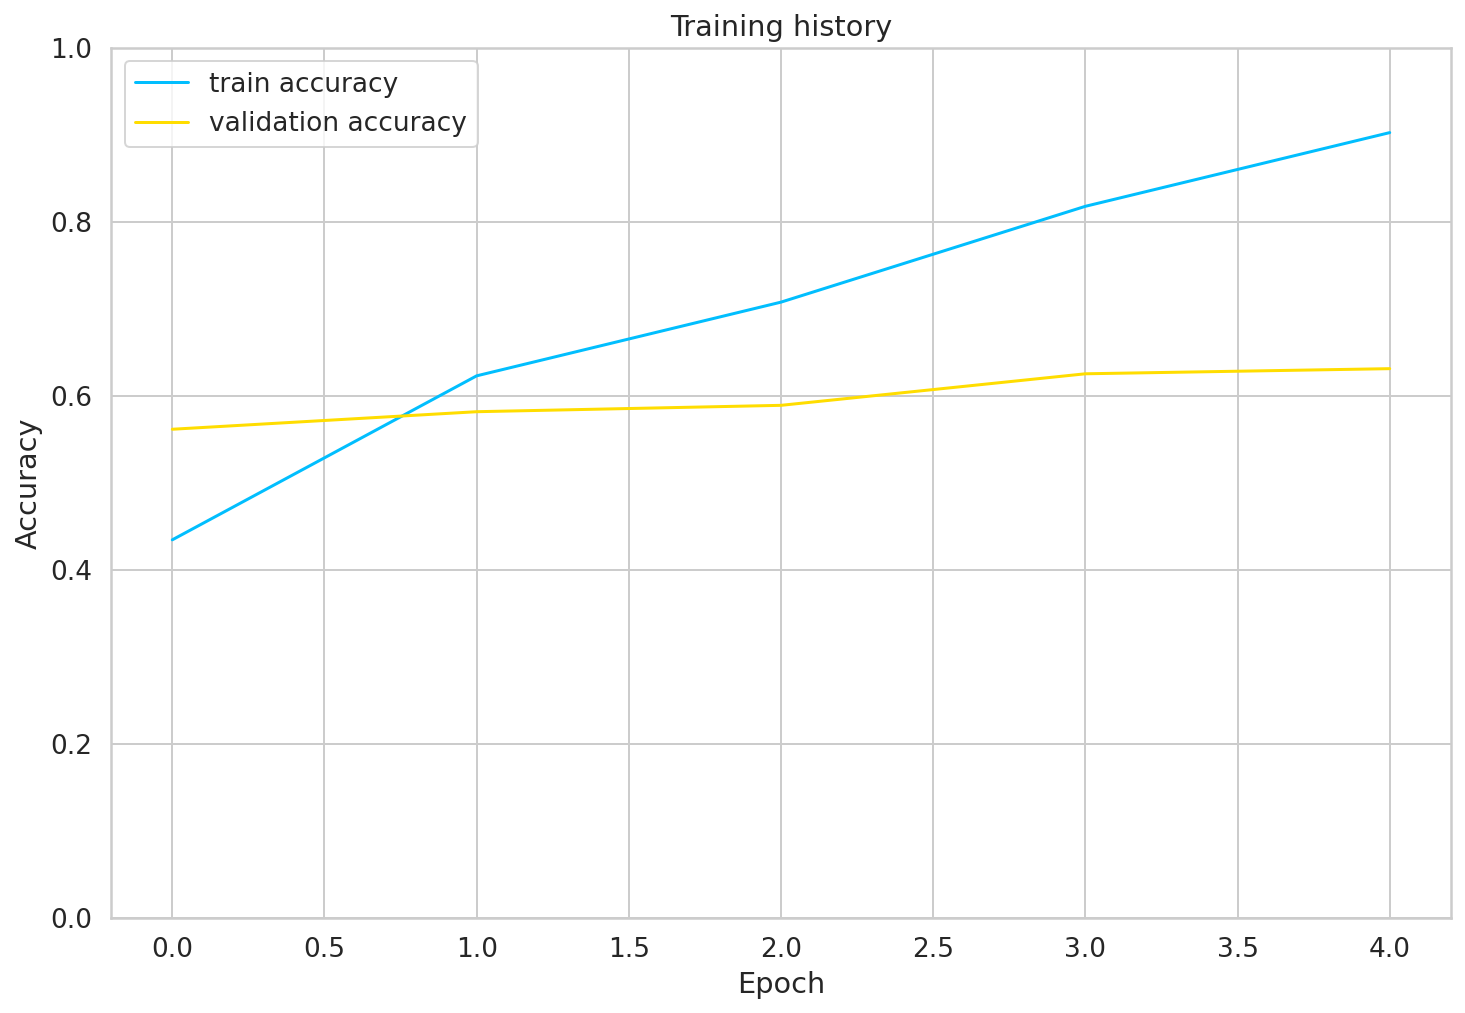

In [48]:
plt.plot(history['train_acc'], label='train accuracy')

plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend()

plt.ylim([0, 1]);

In [49]:
test_acc, _ = eval_model(

  model,

  test_data_loader,

  loss_fn,

  device,

  len(df_test)

)

test_acc.item()

0.6433154379992143

In [50]:
def get_predictions(model, data_loader):

  model = model.eval()

  review_texts = []

  predictions = []

  prediction_probs = []

  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d["review_text"]

      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)

      targets = d["targets"].to(device)

      outputs = model(

        input_ids=input_ids,

        attention_mask=attention_mask

      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)

      predictions.extend(preds)

      prediction_probs.extend(outputs)

      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()

  prediction_probs = torch.stack(prediction_probs).cpu()

  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(

  model,

  test_data_loader

)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

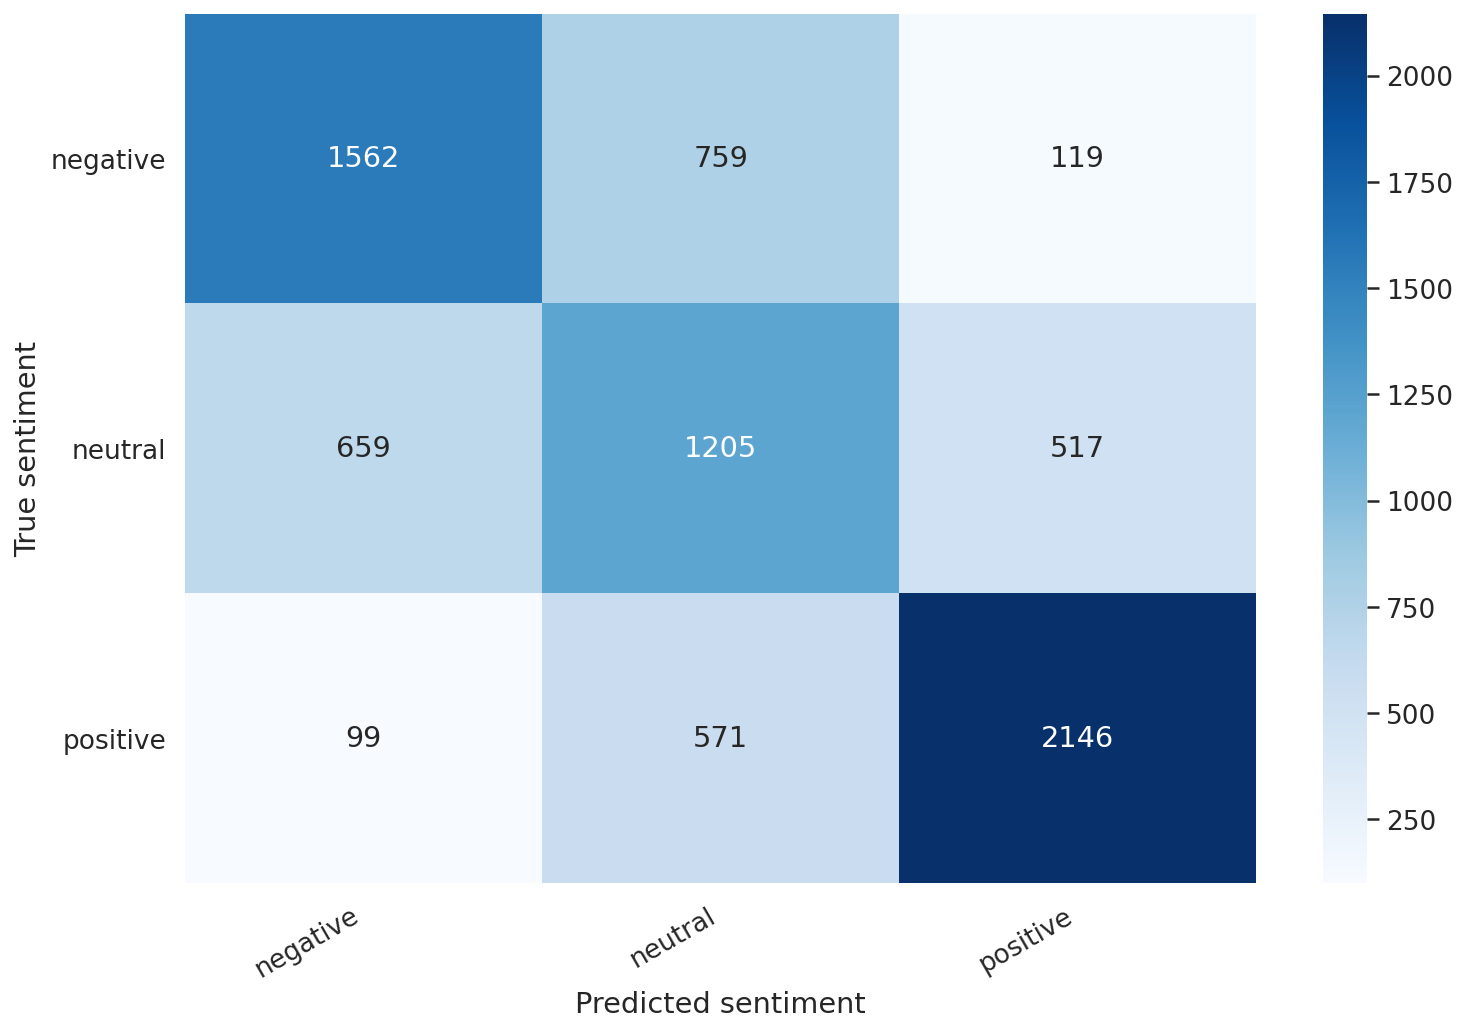

In [59]:
def show_confusion_matrix(confusion_matrix):

  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')

  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

  plt.ylabel('True sentiment')

  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

show_confusion_matrix(df_cm)

In [61]:
idx = 2

review_text = y_review_texts[idx]

true_sentiment = y_test[idx]

pred_df = pd.DataFrame({

  'class_names': class_names,

  'values': y_pred_probs[idx]

})

In [62]:
print("\n".join(wrap(review_text)))

print()

print(f'True sentiment: {class_names[true_sentiment]}')

Buggy as hell. Keeps duplicating events when I edit them leaving me
with the old version and the new side by side. I keep deleting the old
one and it keeps coming back. I'm irritated and I'm going to look
elsewhere now. I loved the original business calendar but after giving
it more then a fair chance this version is a no go.

True sentiment: negative


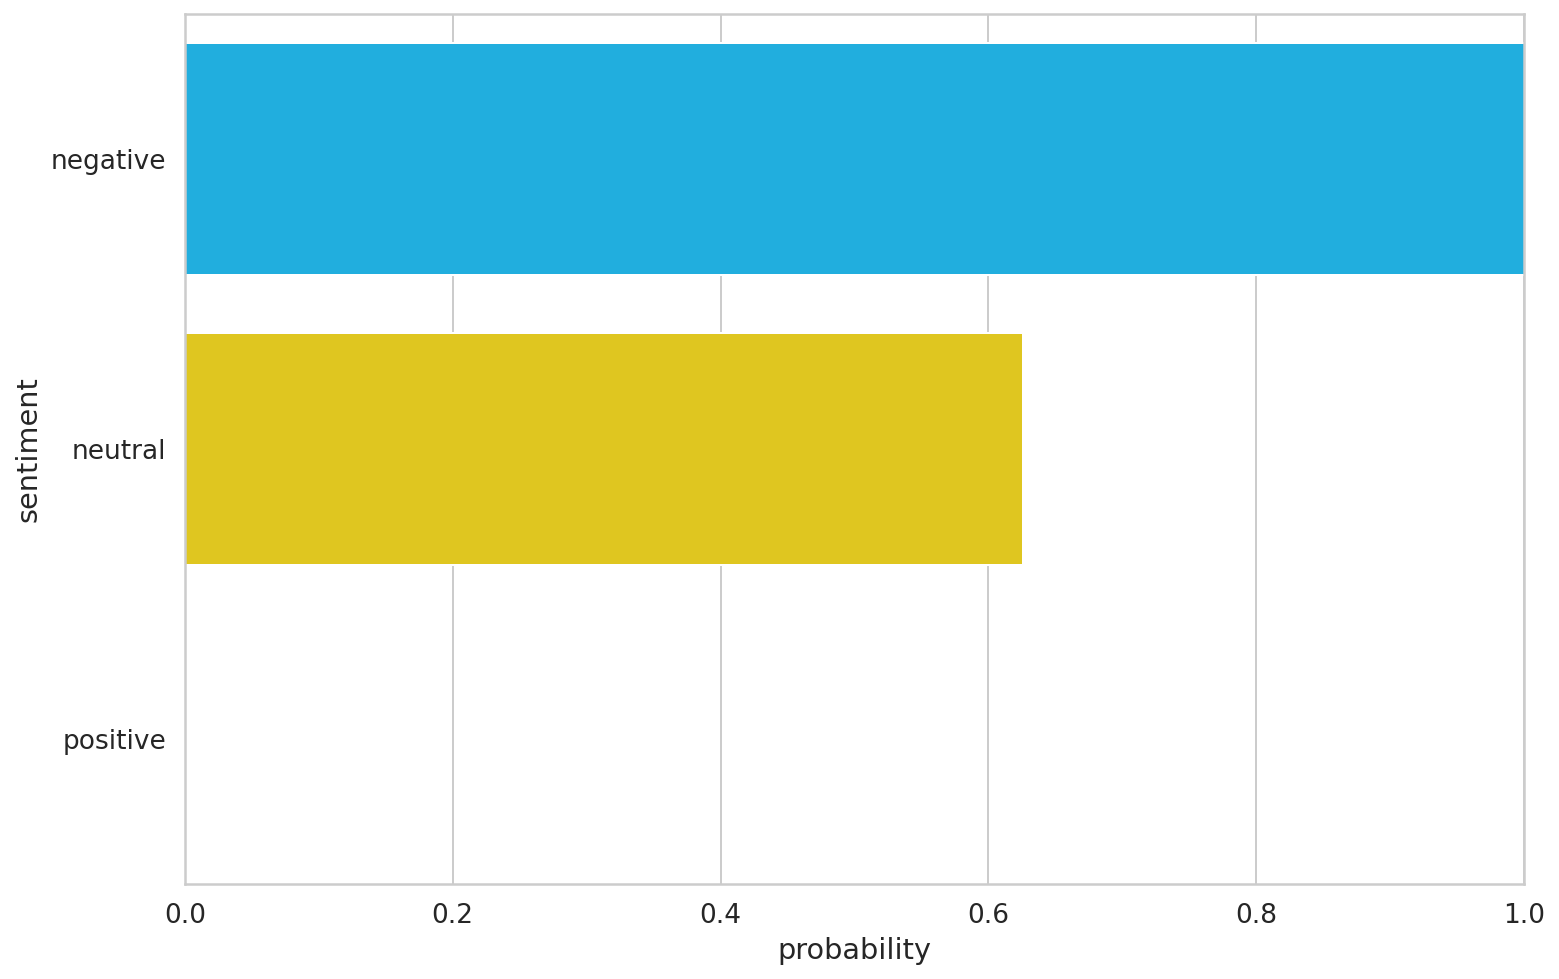

In [63]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')

plt.ylabel('sentiment')

plt.xlabel('probability')

plt.xlim([0, 1]);

In [64]:
review_text = "I love completing my todos! Best app ever!!!"

In [65]:
encoded_review = tokenizer.encode_plus(

  review_text,

  max_length=MAX_LEN,

  add_special_tokens=True,

  return_token_type_ids=False,

  pad_to_max_length=True,

  return_attention_mask=True,

  return_tensors='pt',

)

In [66]:
input_ids = encoded_review['input_ids'].to(device)

attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')

print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
